In [2]:
import random
from typing import Any, Tuple

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [3]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=False, test: bool=False, valid: bool=False) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=False, test: bool=False, valid: bool=False) -> pd.DataFrame:
        data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        data = data.sample(frac=1).reset_index(drop=True)
        data['label'] = data['label'].apply(lambda label: 0 if label == 'leopard' else 1)
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.5)])

In [5]:
train_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, train = True)
test_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, test = True)
valid_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, valid = True)

In [6]:
len(train_data), len(test_data), len(valid_data)

(57, 7, 8)

In [7]:
train_data.data['label'].value_counts()

label
1    30
0    27
Name: count, dtype: int64

In [8]:
test_data.data['label'].value_counts()

label
1    4
0    3
Name: count, dtype: int64

In [9]:
valid_data.data['label'].value_counts()

label
1    4
0    4
Name: count, dtype: int64

In [10]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)
        self.fully_connect1 = nn.Linear(5408, 10)
        self.fully_connect2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [11]:
parameters = {'lr': [0.001, 0.01, 0.1],
              'batch_size' : [16, 32, 48]}

Epoch: 1, train_accuracy: 0.42105263157894735, train_loss: 0.7719210982322693
Epoch: 1, valid_accuracy: 0.5, valid_loss: 0.6777136325836182
Epoch: 2, train_accuracy: 0.49122807017543857, train_loss: 0.6898468732833862
Epoch: 2, valid_accuracy: 0.625, valid_loss: 0.6823866963386536
Epoch: 3, train_accuracy: 0.6842105263157894, train_loss: 0.6696271300315857
Epoch: 3, valid_accuracy: 0.625, valid_loss: 0.661864161491394
Epoch: 4, train_accuracy: 0.7368421052631579, train_loss: 0.6408233642578125
Epoch: 4, valid_accuracy: 0.5, valid_loss: 0.6535598039627075
Epoch: 5, train_accuracy: 0.6491228070175439, train_loss: 0.6245077848434448
Epoch: 5, valid_accuracy: 0.625, valid_loss: 0.6503116488456726
Epoch: 6, train_accuracy: 0.6666666666666667, train_loss: 0.6078299283981323
Epoch: 6, valid_accuracy: 0.625, valid_loss: 0.6325032711029053
Epoch: 7, train_accuracy: 0.6666666666666665, train_loss: 0.5781715512275696
Epoch: 7, valid_accuracy: 0.625, valid_loss: 0.6056577563285828
Epoch: 8, train_

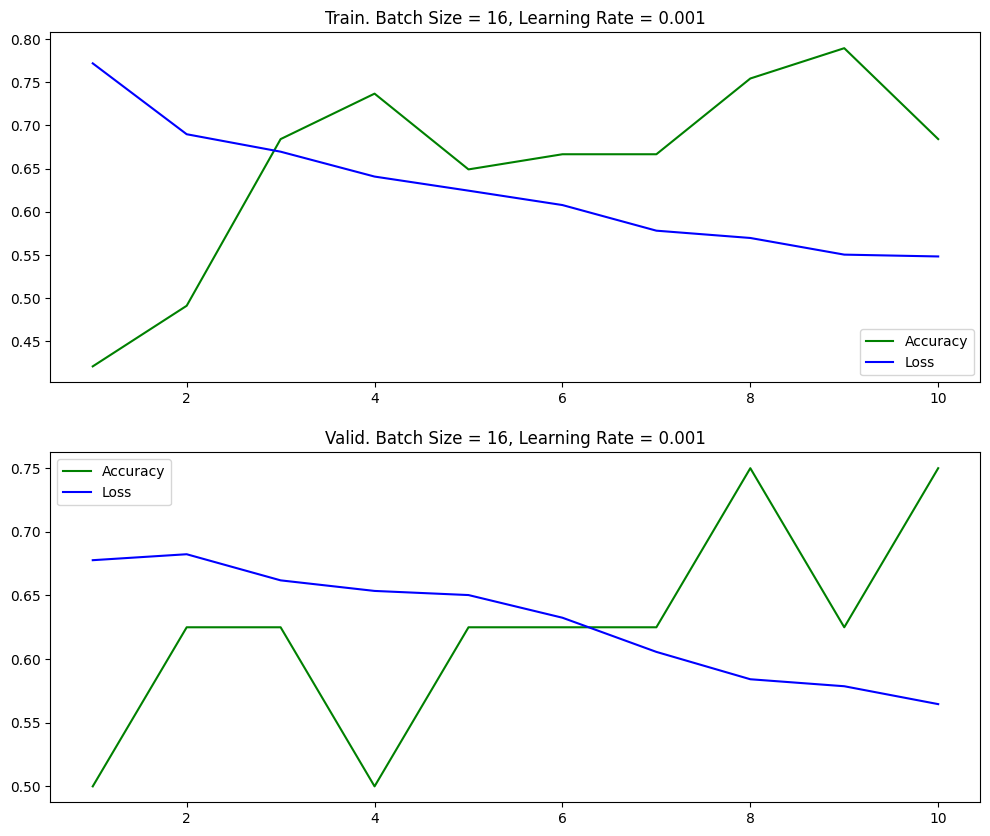

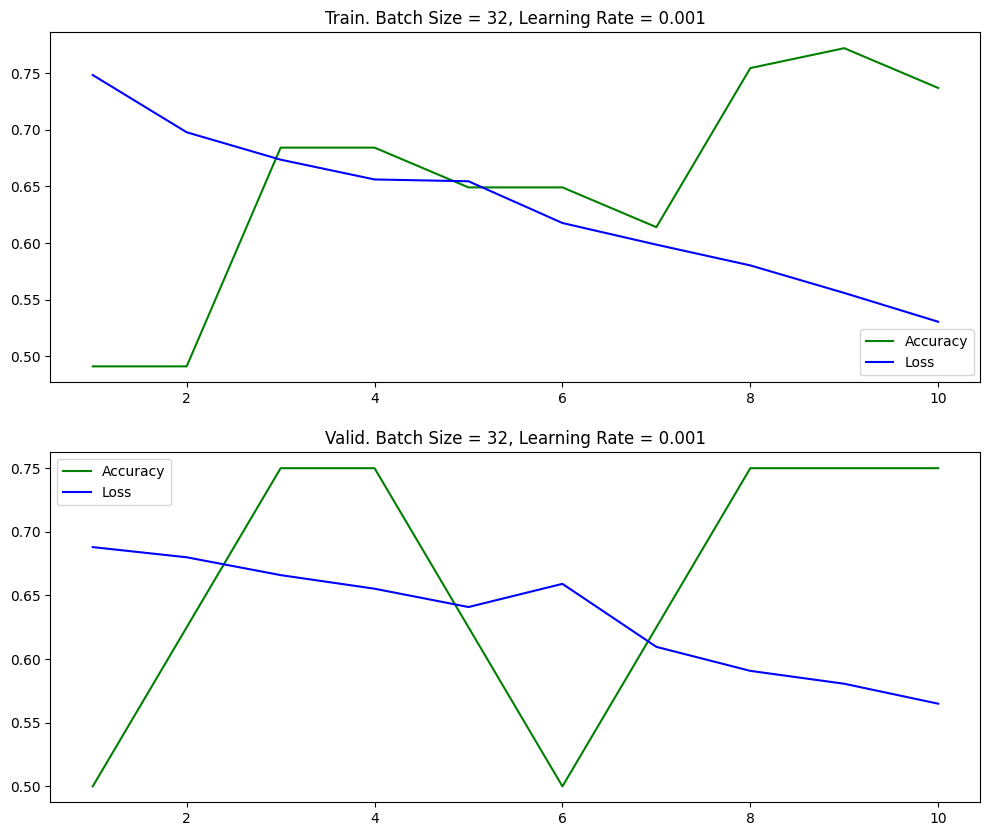

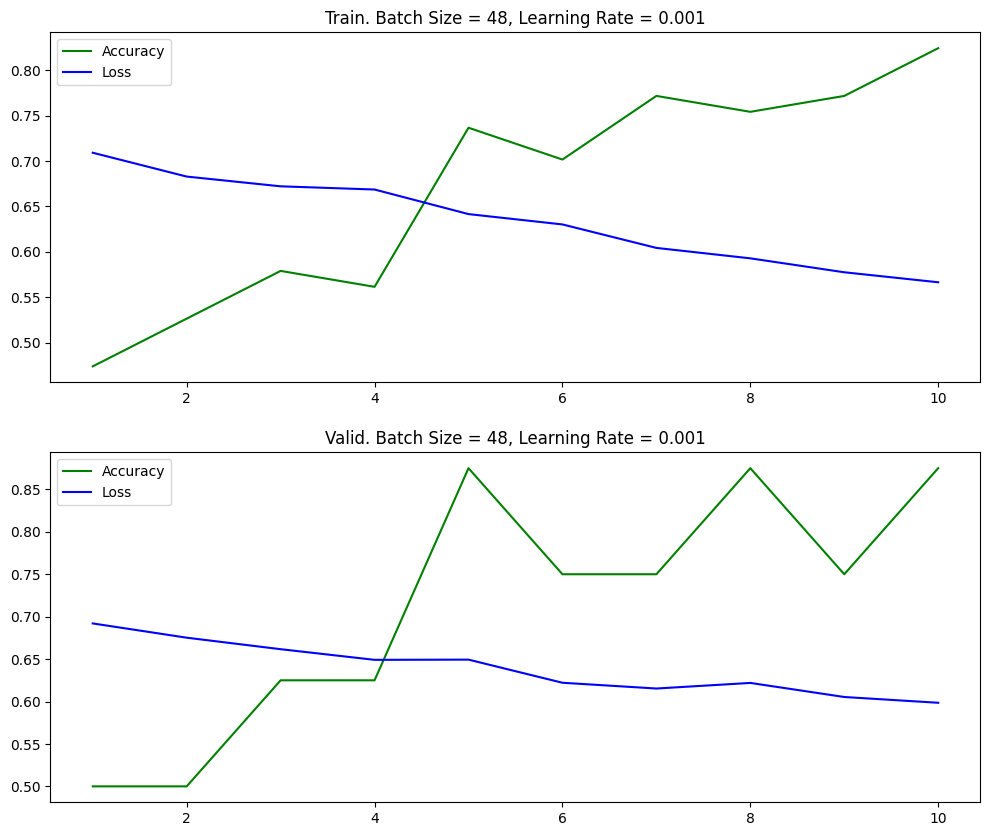

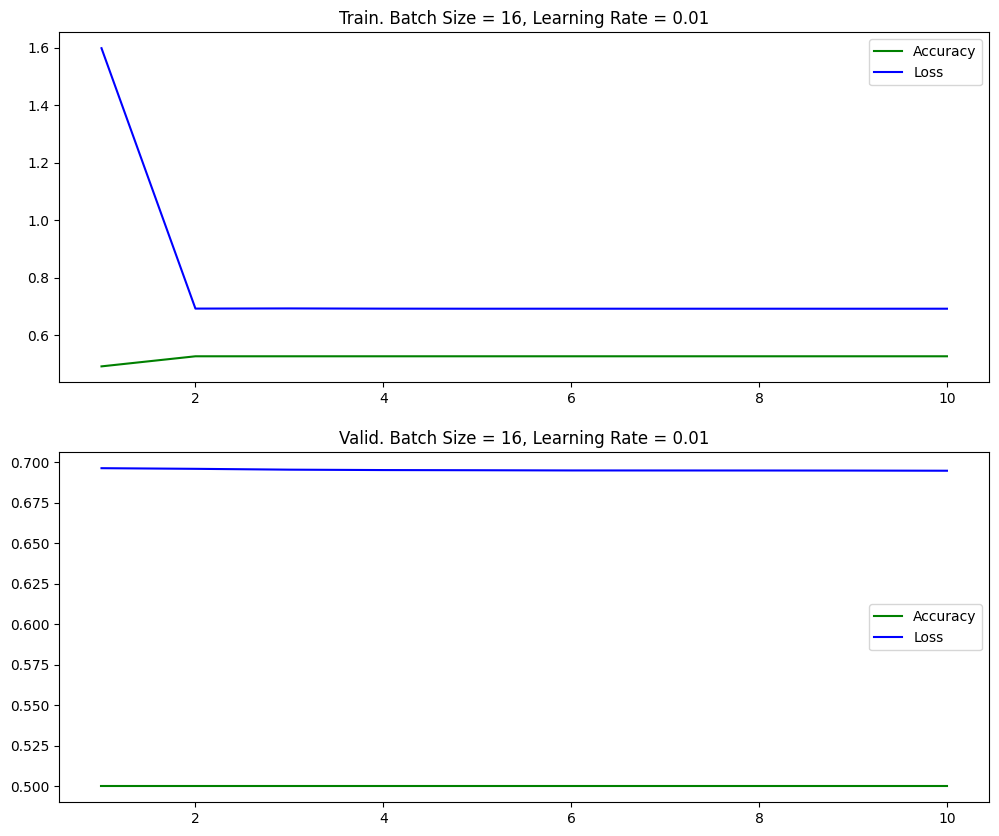

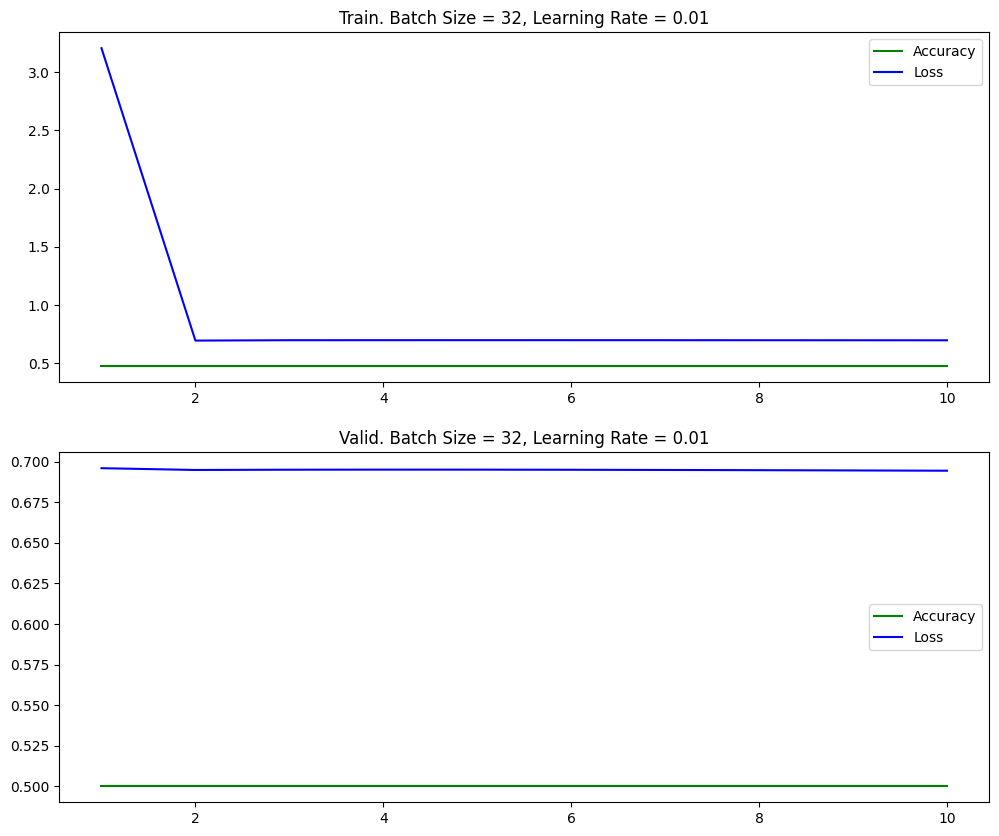

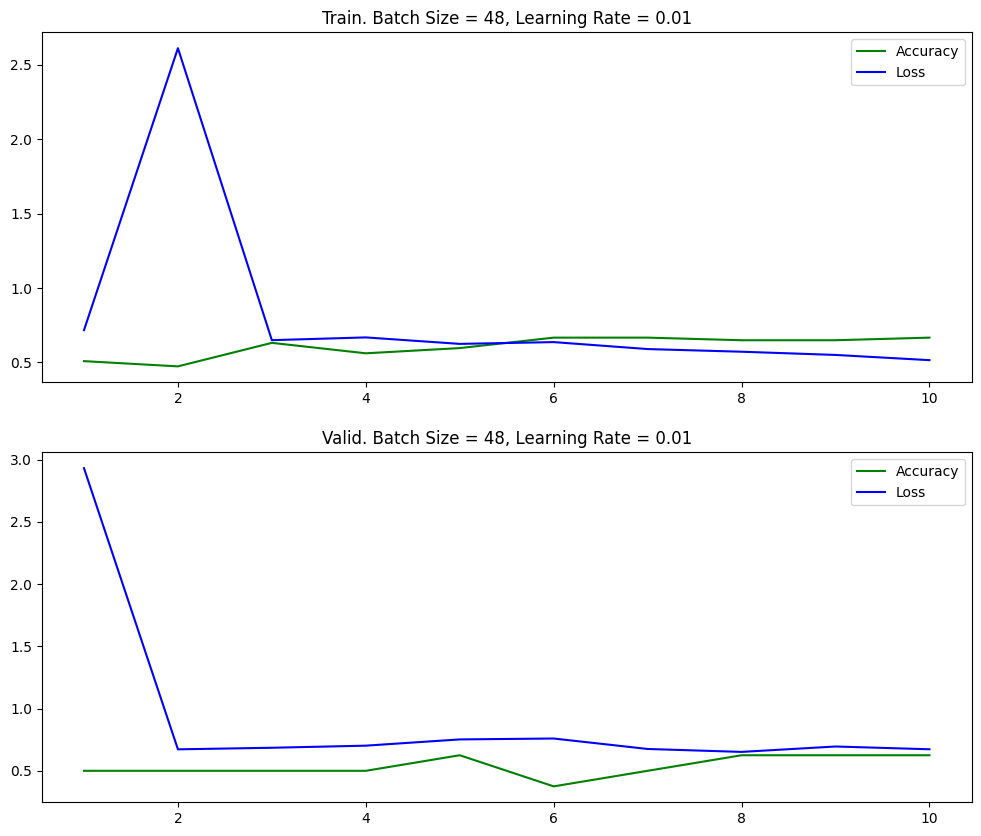

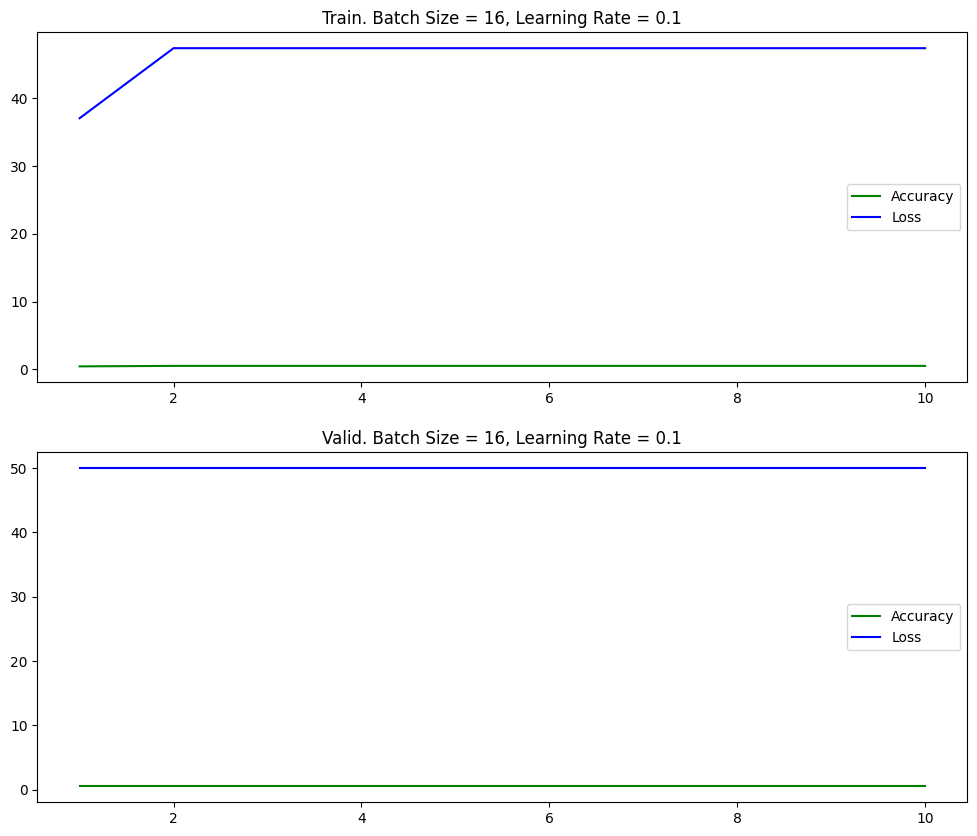

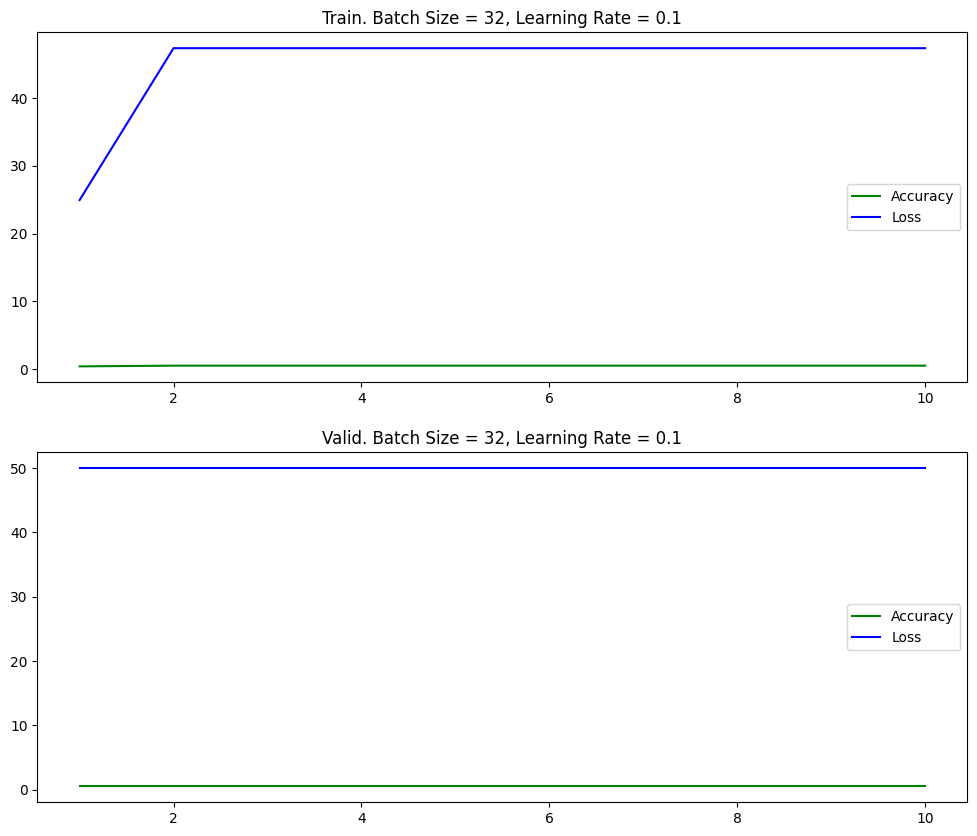

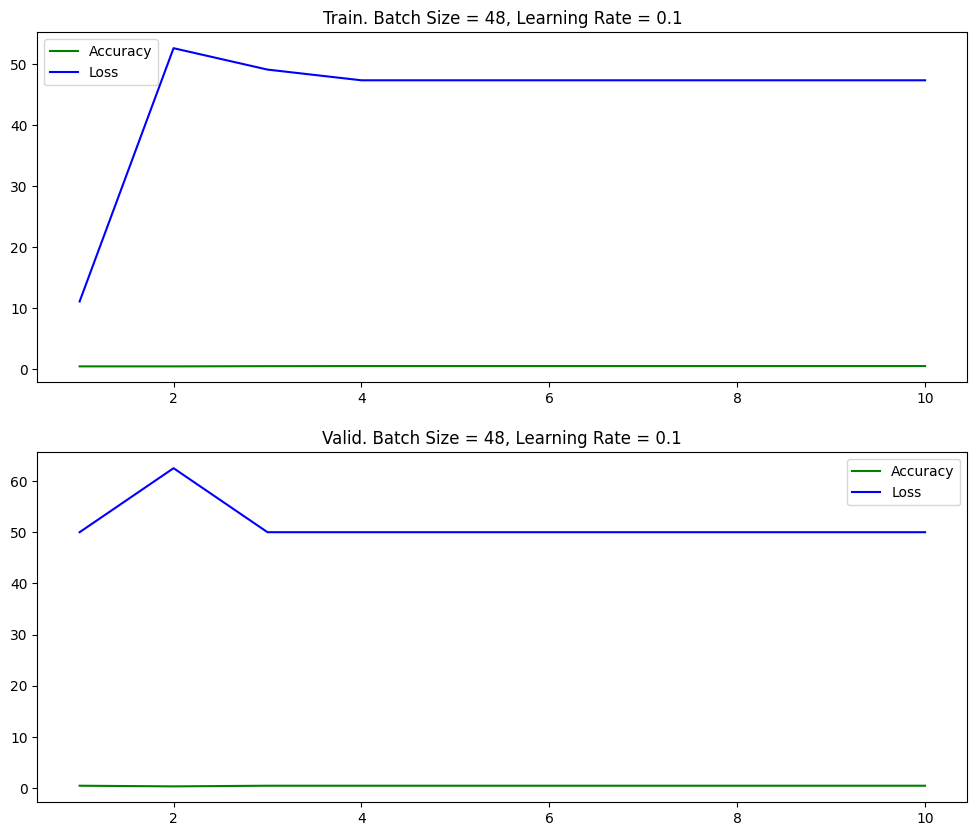

In [12]:
for lr in parameters['lr']:
    for bs in parameters['batch_size']:
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        model = CNN().to(device)

        optimizer = optim.Adam(params=model.parameters(), lr=lr)
        criterion = nn.BCELoss(reduction='sum')

        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 10

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            epoch_accuracy = 0

            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, label in train_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_accuracy += acc / len(train_data)
                epoch_loss += loss / len(train_data)

            model.eval()
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_val_accuracy += acc / len(valid_data)
                epoch_val_loss += loss / len(valid_data)

            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
            print('Epoch: {}, valid_accuracy: {}, valid_loss: {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

        train_loss_values = [value.cpu().detach().numpy() for value in train_loss_values]
        val_loss_values = [value.cpu().detach().numpy() for value in val_loss_values]

        plt.figure(figsize=(12,10))

        plt.subplot(2, 1, 1)
        plt.title(f"Train. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        plt.subplot(2, 1, 2)
        plt.title(f"Valid. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        model.eval()
        test_loss = 0
        test_accuracy = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

            test_accuracy+=acc / len(test_data)
            test_loss+=loss / len(test_data)

        torch.save(model.state_dict(), f"bs{bs}_lr{lr}_weight.pt")

        print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(lr, bs, test_accuracy, test_loss))

In [13]:
best_model = CNN()
best_model.load_state_dict(torch.load("bs32_lr0.001_weight.pt"))
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
best_model.to(device)

CNN(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (fully_connect1): Linear(in_features=5408, out_features=10, bias=True)
  (fully_connect2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


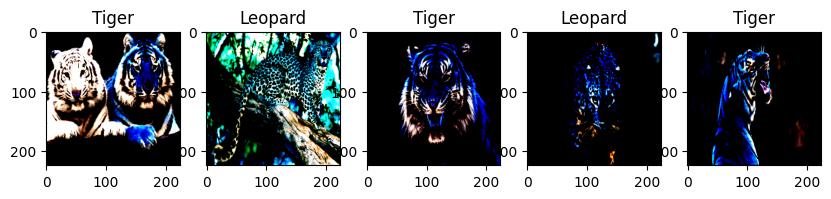

In [14]:
plt.figure(figsize=(10, 5))

for j in range(5):
  index = random.randint(0, len(test_data) - 1)
  plt.subplot(1, 5, j + 1)
  plt.title("Leopard" if (1 if  best_model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "Tiger")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])

In [15]:
bad_model = CNN()
bad_model.load_state_dict(torch.load("bs48_lr0.1_weight.pt"))
bad_model.to(device)

CNN(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (fully_connect1): Linear(in_features=5408, out_features=10, bias=True)
  (fully_connect2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


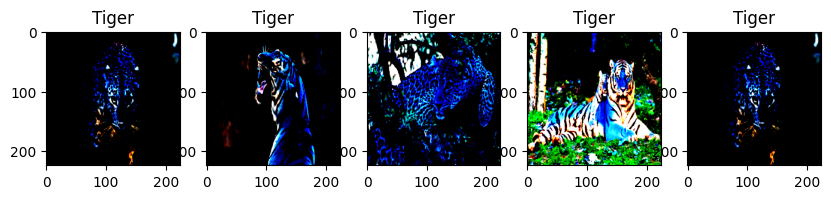

In [16]:
plt.figure(figsize=(10, 5))

for j in range(5):
  index = random.randint(0, len(test_data) - 1)
  plt.subplot(1, 5, j + 1)
  plt.title("Leopard" if (1 if  bad_model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "Tiger")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])